In [2]:
import pandas as pd
import glob
import os
import re

# Find all the part0.parquet files (recursively)
files = glob.glob("./research_network/**/part.1.parquet", recursive=True)

for f in files:
    # Extract folder name (e.g., 'patient.parquet')
    folder_name = os.path.basename(os.path.dirname(f))
    
    # Clean it (remove .parquet)
    var_name = re.sub(r"\.parquet$", "", folder_name)
    
    # Load parquet file
    df = pd.read_parquet(f)
    
    # Create global variable (like patient, diagnosis, etc.)
    globals()[var_name] = df
    
    print(f"✅ Loaded '{var_name}' → shape {df.shape}")


✅ Loaded 'vitals_signs' → shape (2062, 10)
✅ Loaded 'medication_ingredient' → shape (2040, 11)
✅ Loaded 'procedure' → shape (4658, 8)
✅ Loaded 'diagnosis' → shape (2467, 10)
✅ Loaded 'encounter' → shape (3557, 9)
✅ Loaded 'medication_drug' → shape (810, 13)
✅ Loaded 'lab_result' → shape (2140, 10)
✅ Loaded 'patient' → shape (2003, 11)


# Patient

In [37]:
patient.head()

,patient_id,sex,race,ethnicity,marital_status,year_of_birth,reason_yob_missing,month_year_death,death_date_source_id,patient_regional_location,source_id
__null_dask_index__,,,,,,,,,,,
1190,CBCuB,M,Black or African American,Not Hispanic or Latino,Married,1953,Present,None,None,South Atlantic,EHR
1705,CxCwB,F,Black or African American,Not Hispanic or Latino,Married,1963,Present,None,None,South Atlantic,EHR
1707,CRDwB,F,Other Race,Hispanic or Latino,Married,1978,Present,None,None,South Atlantic,EHR
1774,CBUwB,M,Black or African American,Not Hispanic or Latino,Single,1967,Present,None,None,South Atlantic,EHR
2377,CxqyB,M,White,Not Hispanic or Latino,Single,1971,Present,None,None,South Atlantic,EHR


# Encounter

In [38]:
encounter.head()

,encounter_id,patient_id,start_date,end_date,type,start_date_derived_by_TriNetX,end_date_derived_by_TriNetX,derived_by_TriNetX,source_id
__null_dask_index__,,,,,,,,,
3216,Rwo1E,OANL,20110406,None,EMER,F,F,F,EHR
3217,RAp1E,OANL,20110406,None,AMB,F,F,F,EHR
3218,RQp1E,OANL,20120510,None,AMB,F,F,F,EHR
3219,Rg54D,OANL,20121214,None,AMB,F,F,F,EHR
3220,Rgp1E,OANL,20130802,None,AMB,F,F,F,EHR


In [39]:
print(encounter.columns.tolist())


['encounter_id', 'patient_id', 'start_date', 'end_date', 'type', 'start_date_derived_by_TriNetX', 'end_date_derived_by_TriNetX', 'derived_by_TriNetX', 'source_id']


In [40]:
#Number of encounters

encounter["type"].value_counts()




type
AMB        1865
UNKNOWN    1173
IMP         211
EMER        172
LAB          41
HH           30
SS           29
VR           20
OBSENC       15
NONAC         1
Name: count, dtype: int64

In [48]:
#Percentage of distribution for all types of encounters
encounter["type"].value_counts(normalize=True) * 100 

#Amb is outpatient
#IMP is impatient
#EMER is emergency
#OBSENC is short term observational encounter <24 hours
#VR is virtual and telehealth
#SS is short stay/same day surgery
#Unknown is not registered
#HH is home
#NONAC is not acute
#LAB is lab visit etc.
#Not Every part has all types of encounter



type
AMB        52.431825
UNKNOWN    32.977228
IMP         5.931965
EMER        4.835536
LAB         1.152657
HH          0.843407
SS          0.815294
VR          0.562272
OBSENC      0.421704
NONAC       0.028114
Name: proportion, dtype: float64

In [3]:
import pandas as pd
import numpy as np

# --- 0) Start from your encounter DataFrame: `encounter` ---
# Ensure datetimes
for col in ["start_date", "end_date", "start_date_derived_by_TriNetX", "end_date_derived_by_TriNetX"]:
    if col in encounter.columns:
        encounter[col] = pd.to_datetime(encounter[col], errors="coerce")

# Prefer derived dates when present, else raw
encounter["start_dt"] = encounter["start_date_derived_by_TriNetX"].fillna(encounter["start_date"])
encounter["end_dt"]   = encounter["end_date_derived_by_TriNetX"].fillna(encounter["end_date"])

# Normalize: if end is missing or prior to start, set end = start
bad_end = encounter["end_dt"].isna() | (encounter["end_dt"] < encounter["start_dt"])
encounter.loc[bad_end, "end_dt"] = encounter.loc[bad_end, "start_dt"]

# --- 1) Sort for within-patient comparisons ---
encounter = encounter.sort_values(["patient_id", "start_dt", "end_dt"]).reset_index(drop=True)

# Next encounter (within same patient)
encounter["next_encounter_id"] = encounter.groupby("patient_id")["encounter_id"].shift(-1)
encounter["next_type"]         = encounter.groupby("patient_id")["type"].shift(-1)
encounter["next_start"]        = encounter.groupby("patient_id")["start_dt"].shift(-1)
encounter["next_end"]          = encounter.groupby("patient_id")["end_dt"].shift(-1)

# Gaps (days) from this end to next start
encounter["gap_to_next_days"] = (encounter["next_start"] - encounter["end_dt"]).dt.total_seconds() / (24*3600)

# Overlap amount (if next starts before this ends)
encounter["overlap_hours"] = (encounter["end_dt"] - encounter["next_start"]).dt.total_seconds() / 3600.0

# Helper: in-person set (adjust as you wish)
inperson_set = {"AMB", "IMP", "EMER", "OBSENC", "SS", "NONAC", "PRENC"}

# --- 2) Redundancy rules (booleans) ---
# A) Same-day same-type duplicate (different encounter_id)
encounter["redund_same_day_same_type"] = (
    (encounter["next_start"].dt.date == encounter["start_dt"].dt.date) &
    (encounter["type"] == encounter["next_type"]) &
    (encounter["encounter_id"] != encounter["next_encounter_id"])
)

# B) Overlapping encounters (next starts before current ends)
encounter["redund_overlap"] = encounter["overlap_hours"].fillna(-1) > 0

# C) Very short-gap same-type repeat (≤1 day, positive gap)
encounter["redund_shortgap_same_type"] = (
    encounter["gap_to_next_days"].between(0, 1, inclusive="both") &
    (encounter["type"] == encounter["next_type"])
)

# D) VR → in-person within 7 days (cross-modality repeat)
encounter["redund_vr_to_inperson_7d"] = (
    (encounter["type"] == "VR") &
    (encounter["next_type"].isin(inperson_set)) &
    (encounter["gap_to_next_days"].between(0, 7, inclusive="both"))
)

# Aggregate a master flag
redundancy_cols = [
    "redund_same_day_same_type",
    "redund_overlap",
    "redund_shortgap_same_type",
    "redund_vr_to_inperson_7d",
]
encounter["redundant_any"] = encounter[redundancy_cols].any(axis=1)

# --- 3) Pull out candidate redundant PAIRS (left encounter + its next) ---
redund_pairs = encounter.loc[encounter["redundant_any"], [
    "patient_id", "encounter_id", "type", "start_dt", "end_dt",
    "next_encounter_id", "next_type", "next_start", "next_end",
    "gap_to_next_days", "overlap_hours"
] + redundancy_cols].copy()

print("Candidate redundant pairs:", len(redund_pairs))
print(redund_pairs.head())

# --- 4) Quick dashboards ---
summary_counts = encounter[redundancy_cols + ["redundant_any"]].sum().sort_values(ascending=False)
print("\nRedundancy flags (counts):\n", summary_counts)

by_type = encounter.groupby("type")["redundant_any"].mean().sort_values(ascending=False) * 100
print("\n% encounters flagged redundant by type:\n", by_type.round(2))

# Example: how many VR → in-person pairs
vr_pairs = redund_pairs[redund_pairs["redund_vr_to_inperson_7d"]]
print("\nVR→In-person within 7 days pairs:", vr_pairs.shape[0])



Candidate redundant pairs: 1044
   patient_id encounter_id type   start_dt     end_dt next_encounter_id  \
20       #QVQ        CRPBB  IMP 2020-03-11 2020-03-16             CxUBB   
28       #QVQ        CRWBB  AMB 2020-04-15 2020-04-15             CxWBB   
31       #QVQ        ChWBB  AMB 2020-04-15 2020-04-16             CBXBB   
32       #QVQ        CBXBB  AMB 2020-04-15 2020-04-21             CRXBB   
33       #QVQ        CRXBB  AMB 2020-04-16 2020-04-16             ChXBB   

   next_type next_start   next_end  gap_to_next_days  overlap_hours  \
20       AMB 2020-03-12 2020-03-12              -4.0           96.0   
28       AMB 2020-04-15 2020-04-15               0.0            0.0   
31       AMB 2020-04-15 2020-04-21              -1.0           24.0   
32       AMB 2020-04-16 2020-04-16              -5.0          120.0   
33       AMB 2020-04-17 2020-04-17               1.0          -24.0   

    redund_same_day_same_type  redund_overlap  redund_shortgap_same_type  \
20            

/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_29378/2789856824.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  encounter[col] = pd.to_datetime(encounter[col], errors="coerce")
/var/folders/fb/7h951sh934dfyl7wmdyqn_w80000gn/T/ipykernel_29378/2789856824.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  encounter[col] = pd.to_datetime(encounter[col], errors="coerce")


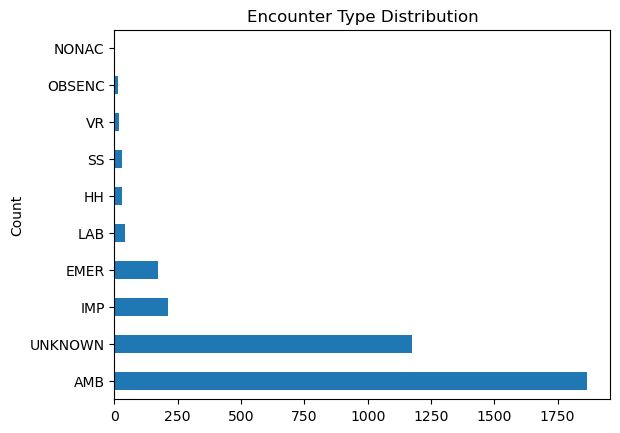

In [18]:
import matplotlib.pyplot as plt
encounter["type"].value_counts().plot(kind="barh", title="Encounter Type Distribution")
plt.ylabel("Count")
plt.show()


<Axes: title={'center': 'Encounters per Year'}, ylabel='year'>

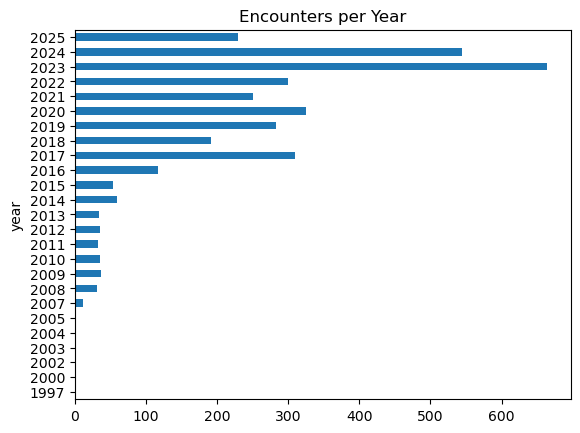

In [19]:
encounter["year"] = encounter["start_dt"].dt.year
encounter["year"].value_counts().sort_index().plot(kind="barh", title="Encounters per Year")


In [16]:
encounter["duration_days"] = (encounter["end_dt"] - encounter["start_dt"]).dt.days
encounter["duration_days"].describe()


count    3557.000000
mean       15.364352
std       142.812397
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2418.000000
Name: duration_days, dtype: float64

# Procedure

In [19]:
procedure.head()

,patient_id,encounter_id,code_system,code,principal_procedure_indicator,date,derived_by_TriNetX,source_id
__null_dask_index__,,,,,,,,
20462,oQWB,rQ8,CPT,96361,Unknown,20160701,F,EHR
20463,oQWB,rg8,CPT,96372,Unknown,20160712,F,EHR
20464,oQWB,rg8,CPT,96372,Unknown,20160713,F,EHR
20465,oQWB,rQ8,CPT,96374,Unknown,20160701,F,EHR
20466,oQWB,rg8,CPT,96374,Unknown,20160712,F,EHR


In [65]:
procedure["code"].value_counts()

code
97530        310
11429006     187
233578004    152
97535        133
80048        124
            ... 
0QB70ZZ        1
0JDM0ZZ        1
J1580          1
99401          1
J1630          1
Name: count, Length: 656, dtype: int64

# Diagnosis

In [20]:
diagnosis.head()

,patient_id,encounter_id,code_system,code,principal_diagnosis_indicator,admitting_diagnosis,reason_for_visit,date,derived_by_TriNetX,source_id
__null_dask_index__,,,,,,,,,,
3104,hgG,kAyN,ICD-10-CM,C22,P,U,U,20210701,F,EHR
3105,hgG,kQyN,ICD-10-CM,C22,P,U,U,20210909,F,EHR
3106,hgG,kQyN,ICD-10-CM,C22,P,U,U,20210909,F,EHR
3107,hgG,kAyN,ICD-10-CM,I10,Unknown,U,U,20210701,F,EHR
3108,hgG,kQyN,ICD-10-CM,I10,Unknown,U,U,20210909,F,EHR


In [60]:
diagnosis["code"].value_counts()

#Code indicate different type of disease

code
I10         117
I73.9        47
E78.5        44
I25.10       42
E11.9        36
           ... 
K50.00        1
S12.000S      1
K50.80        1
K52.89        1
Z88.7         1
Name: count, Length: 631, dtype: int64

Matplotlib is building the font cache; this may take a moment.


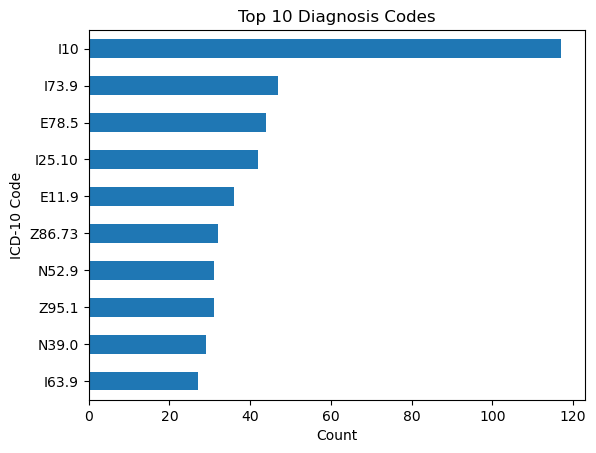

In [61]:
import matplotlib.pyplot as plt

diagnosis["code"].value_counts().head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 Diagnosis Codes")
plt.xlabel("Count")
plt.ylabel("ICD-10 Code")
plt.show()


In [63]:
# Select rows where the diagnosis code starts with "F"
diagnosis_F = diagnosis[diagnosis["code"].str.startswith("F", na=False)]

# Check how many
print("Number of mental/behavioral diagnoses:", diagnosis_F.shape[0])

# View first few
print(diagnosis_F["code"].value_counts().head(10))


Number of mental/behavioral diagnoses: 54
code
F17.200    10
F03.90      8
F17.203     6
F17.210     6
F02.818     5
F32.9       5
F41.9       5
F17.213     2
F01.50      1
F02.80      1
Name: count, dtype: int64


# Lab Results

In [67]:
lab_result.head()

,patient_id,encounter_id,code_system,code,date,lab_result_num_val,lab_result_text_val,units_of_measure,derived_by_TriNetX,source_id
__null_dask_index__,,,,,,,,,,
108781,OQaE,RQbM,LOINC,2345-7,20230327,101,None,mg/dL,F,EHR
108782,OQaE,RQbM,LOINC,38208-5,20230327,10,None,units,F,EHR
108783,OQaE,RQbM,LOINC,38208-5,20230327,0,None,units,F,EHR
605568,FAjD,IwVf,LOINC,10834-0,20170419,39,None,g/L,F,EHR
605569,FAjD,Igaf,LOINC,10834-0,20190424,53,None,g/L,F,EHR


# Vital Signs

In [15]:
vitals_signs.head()

,patient_id,encounter_id,code_system,code,date,value,text_value,units_of_measure,derived_by_TriNetX,source_id
__null_dask_index__,,,,,,,,,,
1346,LhZq,OBEU,LOINC,3141-9,20171211,190,None,[lb_av],F,EHR
1347,LhZq,OBEU,LOINC,39156-5,20171211,26.5,None,kg/m2,F,EHR
1348,LhZq,OBEU,LOINC,8302-2,20171211,71,None,[in_us],F,EHR
56894,Nh7C,QxBG,LOINC,39156-5,20230530,25.67,None,kg/m2,F,EHR
56895,Nh7C,QhBG,LOINC,39156-5,20240501,25.02,None,kg/m2,F,EHR


# Medication Drugs

In [68]:
medication_drug.head()

,patient_id,encounter_id,unique_id,code_system,code,start_date,route,brand,strength,quantity_dispensed,days_supply,derived_by_TriNetX,source_id
__null_dask_index__,,,,,,,,,,,,,
38345,mAoU,pAOC,mAof,RxNorm_drug,352272,20220309,Oral Product,Lexapro,Unknown,None,1,F,EHR
38346,mAoU,pAOC,mQof,RxNorm_drug,352272,20220311,Oral Product,Lexapro,Unknown,None,1,F,EHR
38347,mAoU,pAOC,mw8f,RxNorm_drug,212575,20220223,Oral Product,Norvasc,Unknown,None,1,F,EHR
38348,mAoU,pAOC,mA9f,RxNorm_drug,212575,20220224,Oral Product,Norvasc,Unknown,None,1,F,EHR
38349,mAoU,pAOC,mQ9f,RxNorm_drug,212549,20220307,Oral Product,Norvasc,Unknown,None,1,F,EHR


# Link some tables

In [11]:
enc_diag = encounter.merge(diagnosis, on="encounter_id", how="left")
enc_diag.groupby("type")["code"].value_counts().groupby(level=0).head(5)

# Diagnosis and encounter seems to be different for parquet 0
# More exploration needed after merging data


type     code   
AMB      C56.2      24
         Q68.0      11
         Z23        11
         Z00.129    10
         E66.01      9
EMER     K50.90      7
         Z95.0       7
         I10         6
         F17.200     5
         Z86.73      4
IMP      N18.6      10
         I10         9
         I48.91      7
         Z99.2       7
         E87.5       6
SS       E87.6       1
         F17.203     1
         H65.493     1
         H91.90      1
         I10         1
UNKNOWN  Q68.0      10
         Z23         9
         Z00.129     8
         Q67.3       6
         M43.6       4
VR       H66.90      2
         L81.9       1
Name: count, dtype: int64

In [13]:
enc_per_patient = (
    encounter.groupby("patient_id")["encounter_id"]
    .count()
    .reset_index(name="num_encounters")
    .sort_values("num_encounters", ascending=False)
)

enc_per_patient.head(10)


,patient_id,num_encounters
67,khcm,441
63,hBZ2,409
64,hxE2,401
39,Cxu3,197
3,0gW2,192
5,4Q7j,189
41,HR#T,159
45,OAAB,151
69,rht,114
0,#QVQ,113


In [14]:
enc_per_patient["num_encounters"].describe() #Descriptive statistic for number of encounter


count     71.000000
mean      50.098592
std       91.371011
min        1.000000
25%        3.000000
50%       14.000000
75%       46.000000
max      441.000000
Name: num_encounters, dtype: float64

In [21]:
enc_proc = encounter.merge(procedure, on="encounter_id", how="left")
enc_proc.groupby("type")["code"].nunique()


type
AMB         85
EMER        43
HH           0
IMP        116
LAB          0
NONAC        0
OBSENC       2
SS           1
UNKNOWN     76
VR           0
Name: code, dtype: int64

In [22]:
encounter["redundant_any"].mean() * 100  # % of redundant visits
encounter.groupby("type")["redundant_any"].mean() * 100


type
AMB         26.219839
EMER        15.697674
HH          83.333333
IMP         44.075829
LAB          7.317073
NONAC      100.000000
OBSENC      46.666667
SS          37.931034
UNKNOWN     32.566070
VR          30.000000
Name: redundant_any, dtype: float64

In [26]:
p = encounter[encounter["patient_id"] == encounter["patient_id"].iloc[0]]
p.sort_values("start_dt")[["start_dt","end_dt","type"]]


,start_dt,end_dt,type
0,2007-10-08,2007-10-11,AMB
1,2007-10-25,2007-10-31,AMB
2,2014-11-11,2014-11-11,AMB
3,2015-02-17,2015-02-17,AMB
4,2015-06-17,2015-06-17,AMB
...,...,...,...
108,2025-03-04,2025-03-04,AMB
109,2025-03-04,2025-03-04,AMB
110,2025-03-11,2025-03-11,AMB
111,2025-04-03,2025-04-03,AMB
